##Clumped code cell for ndvi project. Importing libraries, create path, boundaries download and turn into gdf and map, download ndvi stuff usinf appearsdowlader
## NOte, a ###--- means was a seperated cell in the walk through to check the code works

# Install the development version of the earthpy package
!pip install git+https://github.com/earthlab/earthpy@apppears
###----

# import needed libraries
import getpass
import json
import os
import pathlib
from glob import glob

import earthpy.appeears as eaapp
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr
###---

#create a data folder for the project
data_dir = os.path.join(pathlib.Path.home(), 'cameron-peak-fire-data') #name data directory/folder to make sense
# Make the data directory
os.makedirs(data_dir, exist_ok=True)
data_dir  #check the path/folder existence
###---


# Download the area boundary
# Must be attr_incident NOT polygon_incident. This is save potentially hours...-.- Only for WFIGS_Intereagency fire https://data-nifc.opendata.arcgis.com/datasets/5e72b1699bf74eefb3f3aff6f4ba5511_0/api
cameron_peak_url= (
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interagency_Perimeters/FeatureServer/0/query?"
    "where=attr_IncidentName%20%3D%20'CAMERON%20PEAK'"
    "&outFields=*&outSR=4326&f=geojson"    
)
print(cameron_peak_url)

cameron_peak_gdp= gpd.read_file(cameron_peak_url)  #this transforms the link to a  geodataframe aka gdp.shp?
###---

#convert url of boundary to gdf file
cameron_peak_gdp= gpd.read_file(cameron_peak_url)
cameron_peak_gdp.plot()  # map to check
print(type(cameron_peak_gdp)) #check data_type, should be geodata frame
###---

cameron_peak_gdp.hvplot(
    title='Cameron Peak Fire, 2020',
    tiles='CartoDark')
###---



## Dowloading NDVI into the codespace ###
###---
# Initialize AppeearsDownloader for MODIS NDVI data, this puts in a request to the Earth Data and for getting customized data based on the boundary polygon gdf downloaded above
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='cp-ndvi',
    ea_dir=data_dir,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="07-01",
    end_date="07-31",
    recurring=True,
    year_range=[2017, 2023],
    polygon=cameron_peak_gdp
)
ndvi_downloader.download_files(cache=True) #actually donwloads this
###---

# Get list of NDVI tif file paths
ndvi_paths = sorted(glob(os.path.join(data_dir, 'cp-ndvi', '*', '*NDVI*.tif')))
len(ndvi_paths)
###---

#scales data
#Look at the file names. How many characters from the end is the,  date? Replace any required variable names with your chosen variable? names? 
    #Change the `scale_factor` variable to be the correct scale factor
    # for this NDVI dataset (HINT: NDVI should range between 0 and 1)
    # Using indices or regular
scale_factor = 10000
doy_start = -19
doy_end = -12
###---

# GEtting the data into xarray with rxr 
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Multiple by scale factor
    da = da / scale_factor

    # Prepare for concatenation
    ndvi_das.append(da)

len(ndvi_das)
###---

ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_da
###---

#plotting change in NDVI spatially
#temoral mean over time, repeat for other time, subtract, and plot with diverging color map like cmap=plt.cm.PiYG
ndvi_diff = (
    ndvi_da                             #takes th mean over time in chosen month of .NDVI or other datavariable in rxr
        .sel(date=slice('2021', '2023'))
        .mean('date')
        .NDVI 
   - ndvi_da                            #same with diff times and subtracts
        .sel(date=slice('2018', '2020'))
        .mean('date')
        .NDVI
)
(
    ndvi_diff.hvplot(x='x', y='y', cmap='PiYG', geo=True)  # not sure when x or y defined, cmap is the diverging color map, geo makes it spatial I belive
    *
    cameron_peak_gdp.hvplot(geo=True, fill_color=None, line_color='black')   
)
###---

#clips fire boundaries for variable (ie ndvi) analysis
out_of_bounds_cp_gdf = (
    gpd.GeoDataFrame(geometry=cameron_peak_gdp.envelope) 
    .overlay(cameron_peak_gdp, how='difference'))
out_of_bounds_cp_gdf.hvplot()  #this checks that the boundary was cut out
###---

#  Clip data to both inside and outside the boundary
#this make the pressure on memory/processing less, helps prevent kernel crashes and saves time
ndvi_cp_da = ndvi_da.rio.clip(cameron_peak_gdp.geometry, from_disk=True) #inside boundary
ndvi_out_da = ndvi_da.rio.clip(out_of_bounds_cp_gdf.geometry, from_disk=True) #outside of bounds
###---

#For **both inside and outside** the fire boundary:
    # Group the data by year
    # Take the mean. You always need to tell reducing methods in `xarray` what dimensions you want to reduce. When you want to
        #summarize data across **all** dimensions, you can use the `...`
    #  syntax, e.g. `.mean(...)` as a shorthand.
    #Select the choosen variable (ie NDVI)
    # Convert to a DataFrame using the `to_dataframe()` method
    # Join the two DataFrames for plotting using the `.join()` method.
    #You will need to rename the columns using the `lsuffix=` and `rsuffix=` parameters


 #The DateIndex in pandas different from the Datetime dimension in xarray. 
 # in xarray; USE `.dt.year` syntax to access information about the year, NOT just `.year`.

# Compute mean annual July NDVI

# Compute mean annual July NDVI
jul_ndvi_cp_df = (
    ndvi_cp_da
    .groupby(ndvi_cp_da.date.dt.year)
    .mean(...)  
    .NDVI.to_dataframe())
jul_ndvi_out_df = (
    ndvi_out_da
    .groupby(ndvi_out_da.date.dt.year)
    .mean(...)
    .NDVI.to_dataframe())

# Plot inside and outside the reservation
jul_ndvi_df = (
    jul_ndvi_cp_df[['NDVI']]
    .join(
        jul_ndvi_out_df[['NDVI']], 
        lsuffix=' Burned Area', rsuffix=' Unburned Area')
)

jul_ndvi_df.hvplot(
    title='NDVI before and after the Cameron Peak Fire')
###---

# Plot difference inside and outside the reservation
jul_ndvi_df['difference'] = (
    jul_ndvi_df['NDVI Burned Area']
    - jul_ndvi_df['NDVI Unburned Area'])
jul_ndvi_df.difference.hvplot(
    title='Difference between NDVI within and outside the Cameron Peak Fire'
)
###---

In [2]:
# Install the development version of the earthpy package
!pip install git+https://github.com/earthlab/earthpy@apppears
###----


  Cloning https://github.com/earthlab/earthpy (to revision apppears) to /tmp/pip-req-build-e_zppudh
  Running command git clone --filter=blob:none --quiet https://github.com/earthlab/earthpy /tmp/pip-req-build-e_zppudh
  Running command git checkout -b apppears --track origin/apppears
  Switched to a new branch 'apppears'
  Branch 'apppears' set up to track remote branch 'apppears' from 'origin'.
  Resolved https://github.com/earthlab/earthpy to commit 7241165d59af510d62bba312e48c7f513bc9dc05
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:


# import needed libraries
import getpass
import json
import os
import pathlib
from glob import glob

import earthpy.appeears as eaapp
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
###---


In [4]:
#create a data folder for the project
ndvi_data = os.path.join(pathlib.Path.home(), 'Grizzly_Creek_NDVI_Fire_data') #name data directory/folder to make sense
# Make the data directory

**Search for fire boundaries** the [National Interagency Fire Center Wildfire Boundary
>     catalog](https://data-nifc.opendata.arcgis.com/datasets/5e72b1699bf74eefb3f3aff6f4ba5511_0/api) 

In [5]:
# Download the area boundary

# Must be attr_incident NOT polygon_incident. This may save much time...-.-
bounds_url= (
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interagency_Perimeters/FeatureServer/0/query?where=attr_IncidentName%20%3D%20%27GRIZZLY%20CREEK%27&outFields=*&outSR=4326&f=json")
print(bounds_url)
bounds_gdf= gpd.read_file(bounds_url)  #this transforms the link to a  geodataframe aka gdp.shp?
###---




https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interagency_Perimeters/FeatureServer/0/query?where=attr_IncidentName%20%3D%20%27GRIZZLY%20CREEK%27&outFields=*&outSR=4326&f=json


/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime withou

In [6]:
#look at the data, see how many incidents are found. Are these what you are looking for? If multiple, look at them and notice some differenced
#in this there are two, GPS_walked and Infared Imaged under the poly_MapMethod, 
bounds_gdf

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,...,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,Shape__Area,Shape__Length,attr_IncidentComplexityLevel,geometry
0,11275,13459,Grizzly Creek,Wildfire Final Fire Perimeter,GPS-Walked,322.00,NaT,2023-03-14 15:13:42.810000+00:00,2020-09-05 03:13:00+00:00,{3478A04D-5A7E-4E89-9342-80DE610BA9B3},...,FODR,None,None,None,{6668D67B-68EE-4CF8-AC3E-EAAD67743DA1},d5a38ca3-2c28-45eb-b06c-ca4394ecd056,0.000143,0.079356,None,"POLYGON ((-122.40703 42.27382, -122.40700 42.2..."
1,14453,13272,Grizzly Creek,Wildfire Final Fire Perimeter,Infrared Image,32431.62,NaT,2023-03-14 15:13:42.810000+00:00,2020-09-04 00:37:00+00:00,{BC150C8C-D9C8-4C14-8725-2B84D7695302},...,FODR,None,None,None,{E4E21DCE-C8EE-4133-B9F7-5CA2E5FBF79C},c9133643-c537-4030-a059-04d80c6c3a96,0.013763,1.346520,None,"MULTIPOLYGON (((-107.19151 39.66880, -107.1914..."


In [7]:
# in this cell we pick the incident we want for our boundary
# gdfs start at 0, the .loc[[#]] chooses the incident, or object, # from the list. In this case, we wanted incident 1
# this resest bounds_gdf to be only the selected object choosen via .loc[[]]
bounds_gdf = bounds_gdf.loc[[1]]
bounds_gdf

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,...,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,Shape__Area,Shape__Length,attr_IncidentComplexityLevel,geometry
1,14453,13272,Grizzly Creek,Wildfire Final Fire Perimeter,Infrared Image,32431.62,NaT,2023-03-14 15:13:42.810000+00:00,2020-09-04 00:37:00+00:00,{BC150C8C-D9C8-4C14-8725-2B84D7695302},...,FODR,None,None,None,{E4E21DCE-C8EE-4133-B9F7-5CA2E5FBF79C},c9133643-c537-4030-a059-04d80c6c3a96,0.013763,1.34652,None,"MULTIPOLYGON (((-107.19151 39.66880, -107.1914..."


<class 'geopandas.geodataframe.GeoDataFrame'>


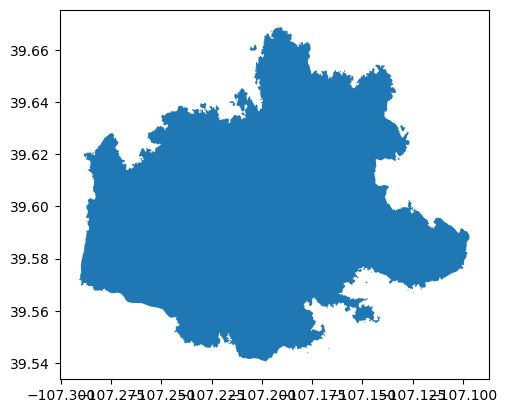

In [8]:
# test plot the boundary

bounds_gdf.plot()  # map to check
print(type(bounds_gdf)) # this checks the object type
###---

In [9]:
bounds_gdf.hvplot(
    title='Grizzly Creek Fire Boundary, 2020',
    tiles='ESRI',
    geo=True) #this makes the base map actually work, tiles='x' alone does not do the job
###---

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [9]:
%%bash
ls ~

Bear_Creek_fire_data
environment.yml
Grizzly_Creek_NDVI_Fire_data
work


In [15]:
## Dowloading NDVI into the codespace ###
###---
# Initialize AppeearsDownloader for MODIS NDVI data, this puts in a request to the Earth Data and for getting customized data based on the boundary polygon gdf downloaded above
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='july_cp-ndvi',
    ea_dir=ndvi_data,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="07-01",
    end_date="07-31",
    recurring=True,
    year_range=[2018, 2023],
    polygon=bounds_gdf
)
ndvi_downloader.download_files(cache=True) #actually donwloads this
###---



In [ ]:
## Dowloading NDVI into the codespace ###
###---
# Initialize AppeearsDownloader for MODIS NDVI data, this puts in a request to the Earth Data and for getting customized data based on the boundary polygon gdf downloaded above
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='june_cp-ndvi',
    ea_dir=ndvi_data,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="06-01",
    end_date="06-31",
    recurring=True,
    year_range=[2018, 2023],
    polygon=bounds_gdf
)
ndvi_downloader.download_files(cache=True) #actually donwloads this
###---



In [12]:
## Grizzly Creek - HLS Download

# Initialize AppeearsDownloader for MODIS NDVI data, this puts in a request to the Earth Data and for getting customized data based on the boundary polygon gdf downloaded above
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='august_cp-ndvi',
    ea_dir=ndvi_data,
    product='HLSL30.020',
    layer='B05',
    start_date="08-01",
    end_date="08-31",
    recurring=True,
    year_range=[2018, 2023],
    polygon=bounds_gdf
)
ndvi_downloader.download_files(cache=True) #actually donwloads this
###---



In [16]:
# Get list of NDVI tif file paths
july_ndvi_paths = sorted(glob(os.path.join(ndvi_data, 'july_cp-ndvi', '*', '*NDVI*.tif')))
len(july_ndvi_paths)
###---
july_ndvi_paths



['/home/jovyan/Grizzly_Creek_NDVI_Fire_data/july_cp-ndvi/MOD13Q1.061_2018167_to_2023212/MOD13Q1.061__250m_16_days_NDVI_doy2018177_aid0001.tif',
 '/home/jovyan/Grizzly_Creek_NDVI_Fire_data/july_cp-ndvi/MOD13Q1.061_2018167_to_2023212/MOD13Q1.061__250m_16_days_NDVI_doy2018193_aid0001.tif',
 '/home/jovyan/Grizzly_Creek_NDVI_Fire_data/july_cp-ndvi/MOD13Q1.061_2018167_to_2023212/MOD13Q1.061__250m_16_days_NDVI_doy2018209_aid0001.tif',
 '/home/jovyan/Grizzly_Creek_NDVI_Fire_data/july_cp-ndvi/MOD13Q1.061_2018167_to_2023212/MOD13Q1.061__250m_16_days_NDVI_doy2019177_aid0001.tif',
 '/home/jovyan/Grizzly_Creek_NDVI_Fire_data/july_cp-ndvi/MOD13Q1.061_2018167_to_2023212/MOD13Q1.061__250m_16_days_NDVI_doy2019193_aid0001.tif',
 '/home/jovyan/Grizzly_Creek_NDVI_Fire_data/july_cp-ndvi/MOD13Q1.061_2018167_to_2023212/MOD13Q1.061__250m_16_days_NDVI_doy2019209_aid0001.tif',
 '/home/jovyan/Grizzly_Creek_NDVI_Fire_data/july_cp-ndvi/MOD13Q1.061_2018167_to_2023212/MOD13Q1.061__250m_16_days_NDVI_doy2020177_aid000

In [18]:
#scales data
#Look at the file names. How many characters from the end is the,  date? Replace any required variable names with your chosen variable? names? 
    #Change the `scale_factor` variable to be the correct scale factor
    # for this NDVI dataset (HINT: NDVI should range between 0 and 1)
    # Using indices or regular
scale_factor = 10000
doy_start = -19
doy_end = -12
###---



In [22]:
# GEtting the data into xarray with rxr 
#these can stay the same unless year wants to be changed
july_ndvi_das = []
for july_ndvi_path in july_ndvi_paths:
    # Get date from file name
    doy = july_ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(july_ndvi_path, masked=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Multiple by scale factor
    da = da / scale_factor

    # Prepare for concatenation
    july_ndvi_das.append(da)

len(july_ndvi_das)

july_ndvi_da = xr.combine_by_coords(july_ndvi_das, coords=['date'])

july_ndvi_da
###---



<xarray.Dataset>
Dimensions:      (x: 94, y: 63, date: 18)
Coordinates:
    band         int64 1
  * x            (x) float64 -107.3 -107.3 -107.3 ... -107.1 -107.1 -107.1
  * y            (y) float64 39.67 39.67 39.67 39.66 ... 39.55 39.54 39.54 39.54
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2018-06-26 2018-07-12 ... 2023-07-28
Data variables:
    NDVI         (date, y, x) float32 0.5276 0.6532 0.6496 ... 0.5683 0.5706

In [23]:
july_ndvi_da = xr.combine_by_coords(july_ndvi_das, coords=['date'])
july_ndvi_da

<xarray.Dataset>
Dimensions:      (x: 94, y: 63, date: 18)
Coordinates:
    band         int64 1
  * x            (x) float64 -107.3 -107.3 -107.3 ... -107.1 -107.1 -107.1
  * y            (y) float64 39.67 39.67 39.67 39.66 ... 39.55 39.54 39.54 39.54
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2018-06-26 2018-07-12 ... 2023-07-28
Data variables:
    NDVI         (date, y, x) float32 0.5276 0.6532 0.6496 ... 0.5683 0.5706

In [24]:
#plotting change in NDVI spatially
#temoral mean over time, repeat for other time, subtract, and plot with diverging color map like cmap=plt.cm.PiYG
july_ndvi_diff = (
    july_ndvi_da                             #takes th mean over time in chosen month of .NDVI or other datavariable in rxr
        .sel(date=slice('2021', '2023'))
        .mean('date')
        .NDVI 
   - july_ndvi_da                            #same with diff times and subtracts
        .sel(date=slice('2018', '2020'))
        .mean('date')
        .NDVI
)
(
    july_ndvi_diff.hvplot(x='x', y='y', cmap='PiYG', geo=True)  # not sure when x or y defined, cmap is the diverging color map, geo makes it spatial I belive
    *
    bounds_gdf.hvplot(geo=True, 
                      
                      fill_color=None, 
                      line_color='black', )

)
###---



:Overlay
   .Image.I    :Image   [x,y]   (NDVI)
   .Polygons.I :Polygons   [Longitude,Latitude]

In [25]:
#clips fire boundaries for variable (ie ndvi) analysis
july_out_of_bounds_gc_gdf = (
    gpd.GeoDataFrame(geometry=bounds_gdf.envelope) 
    .overlay(bounds_gdf, how='difference'))
july_out_of_bounds_gc_gdf.hvplot()  #this checks that the boundary was cut out
###---



:Polygons   [x,y]

In [28]:
#  Clip data to both inside and outside the boundary
#this make the pressure on memory/processing less, helps prevent kernel crashes and saves time
july_ndvi_gc_da = july_ndvi_da.rio.clip(bounds_gdf.geometry, from_disk=True) #inside boundary
july_ndvi_out_da = july_ndvi_da.rio.clip(july_out_of_bounds_gc_gdf.geometry, from_disk=True) #outside of bounds
###---



In [30]:
#For **both inside and outside** the fire boundary:
    # Group the data by year
    # Take the mean. You always need to tell reducing methods in `xarray` what dimensions you want to reduce. When you want to
        #summarize data across **all** dimensions, you can use the `...`
    #  syntax, e.g. `.mean(...)` as a shorthand.
    #Select the choosen variable (ie NDVI)
    # Convert to a DataFrame using the `to_dataframe()` method
    # Join the two DataFrames for plotting using the `.join()` method.
    #You will need to rename the columns using the `lsuffix=` and `rsuffix=` parameters


 #The DateIndex in pandas different from the Datetime dimension in xarray. 
 # in xarray; USE `.dt.year` syntax to access information about the year, NOT just `.year`.

# Compute mean annual July NDVI

# Compute mean annual July NDVI
july_ndvi_gc_df = (
    july_ndvi_gc_da
    .groupby(july_ndvi_gc_da.date.dt.year)
    .mean(...)  
    .NDVI.to_dataframe())
july_ndvi_out_df = (
    july_ndvi_out_da
    .groupby(july_ndvi_out_da.date.dt.year)
    .mean(...)
    .NDVI.to_dataframe())

# Plot inside and outside the reservation
july_ndvi_df = (
    july_ndvi_gc_df[['NDVI']]
    .join(
        july_ndvi_out_df[['NDVI']], 
        lsuffix=' Burned Area', rsuffix=' Unburned Area')
)

july_ndvi_df.hvplot(
    title='NDVI before and after the Grizzly Creek Fire in July')
###---

:NdOverlay   [Variable]
   :Curve   [year]   (value)

In [31]:
# Plot difference inside and outside the boundary
july_ndvi_df['difference'] = (
    july_ndvi_df['NDVI Burned Area']
    - july_ndvi_df['NDVI Unburned Area'])
july_ndvi_df.difference.hvplot(
    title='Difference between NDVI within and outside the Grizzly Creek Fire, May-July 2018 vs 2023',
    fontsize= 11
)
###---

:Curve   [year]   (difference)